In [1]:
# Note: this notebook was designed with the Roboto Condensed font, which can be installed here: https://www.1001fonts.com/roboto-condensed-font.html

from IPython.display import HTML
HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} h2 {padding: 10px 12px; background-color: #E64626; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render h1 { font-size: 30px; } h1 {padding: 10px 12px; background-color: #E64626; color: #ffffff; font-size: 40px;} .text_cell_render h3 { padding: 10px 12px; background-color: #0148A4; position: static; color: #ffffff; font-size: 20px;} h4:before{ 
    content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} .text_cell_render h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #FFB800; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
''')

# Preparation

## Import packages

In [2]:
# Import packages
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
import sqlalchemy
from sqlalchemy import text
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json
import os
import scipy.stats as stats
import numpy as np
import seaborn as sns


## Helper functions

In [3]:
# useful functions (Reference: week 10 tutorial)

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['database']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

db, conn = pgconnect(credentials)

Connected successfully.


In [4]:
# helper function for geometry data

def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

In [5]:
query(conn, 'select PostGIS_Version()')

,postgis_version
0,3.3 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


In [6]:
from sqlalchemy import inspect
inspect(db).get_schema_names()
db.table_names(schema='public')

/var/folders/rj/zy76hkgs4db193fj89bkfcnm0000gn/T/ipykernel_35146/3825458180.py:3: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  db.table_names(schema='public')


['spatial_ref_sys',
 'stops',
 'polls',
 'primaryschool',
 'secondaryschool',
 'futureschool',
 'schools',
 'population',
 'sa2',
 'income',
 'business',
 'safety',
 'playground',
 'rain_gardens',
 'score',
 'newscore',
 'updatedscore']

## For SQL

In [7]:
postgis_ext = "CREATE EXTENSION IF NOT EXISTS postgis;"
conn.execute(postgis_ext)

# Task 1: Import all datasets (clean if required) into your PostgreSQL server, using a well-defined data schema.


## Import datasets

In [8]:
sa2_path = "./datasets/SA2_2021_AUST_SHP_GDA2020"
sa2 = gpd.read_file(os.path.join(sa2_path, "SA2_2021_AUST_GDA2020.shp"))
print(sa2.shape)

business = pd.read_csv("./datasets/Businesses.csv")
print(business.shape)

stops = pd.read_csv("./datasets/Stops.txt")
print(stops.shape)

polls = pd.read_csv("./datasets/PollingPlaces2019.csv")
print(polls.shape)

school_path = "./datasets/catchments/"
school_primary = gpd.read_file(os.path.join(school_path, "catchments_primary.shp"))
school_secondary = gpd.read_file(os.path.join(school_path, "catchments_secondary.shp"))
school_future = gpd.read_file(os.path.join(school_path, "catchments_future.shp"))
print(school_primary.shape)
print(school_secondary.shape)
print(school_future.shape)

population = pd.read_csv("./datasets/Population.csv")
print(population.shape)

income = pd.read_csv("./datasets/Income.csv")
print(income.shape)

(2473, 17)
(12217, 11)
(114718, 9)
(2930, 17)
(1662, 19)
(436, 19)
(30, 18)
(373, 21)
(576, 6)


## Data Cleaning

### Business

In [9]:
# filter to greater sydney
sa2 = sa2[sa2["GCC_NAME21"] == "Greater Sydney"]

In [10]:
#Renaming for business
business.rename(columns={
    'industry_code': 'code',
    'industry_name': 'name',
    '0_to_50k_businesses': 'turnover_0_to_50k',
    '50k_to_200k_businesses': 'turnover_50_to_200k',
    '200k_to_2m_businesses': 'turnover_200_to_2m',
    '2m_to_5m_businesses': 'turnover_2m_to_5m',
    '5m_to_10m_businesses': 'turnover_5m_to_10m',
    '10m_or_more_businesses': 'turnover_greater_than_10m',
}, inplace=True)

### Stops

In [11]:
# cleaning for stops
stops = stops.drop(['location_type','wheelchair_boarding','platform_code'], axis=1)

stops.rename(columns={
    'stop_id': 'id',
    'stop_code': 'code',
    'stop_name': 'name',
    'stop_lat': 'lat',
    'stop_lon': 'lng',
    }, inplace=True)

stops['geom'] = gpd.points_from_xy(stops.lng, stops.lat)
# stops = stops.drop(columns=['lat', 'lng'])

for column in stops:
    stops.dropna(subset=[column], inplace=True)

### Polls

In [12]:
# cleaning for polls 
polls = polls.drop(['state','premises_address_1','premises_address_2','premises_address_3','premises_suburb','premises_state_abbreviation','premises_name','premises_post_code','the_geom'], axis = 1)

polls.rename(columns={
    'FID' : 'fid',
    'division_id': 'id',
    'division_name': 'name', 
    'polling_place_id': 'polling_id',
    'polling_place_type_id': 'type_id',
    'polling_place_name': 'place_name',
    'latitude': 'lat',
    'longitude': 'lng',
}, inplace=True)

polls['geom'] = gpd.points_from_xy(polls.lng, polls.lat)  
# polls = polls.drop(columns=['lat', 'lng'])  # removing the old latitude/longitude fields

for column in polls:
    polls.dropna(subset=[column], inplace=True)

### Population

In [13]:
# categorise young people
population['young_people'] = population['0-4_people'] + population['5-9_people'] + population['10-14_people'] + population['15-19_people']

# filter to total population > 100
population = population[population['total_people'] > 100]

In [14]:
# rename population variables following the coding convention
population = population.rename(columns={
    '0-4_people': 'people_0_4',
    '5-9_people': 'people_5_9',
    '10-14_people': 'people_10_14',
    '15-19_people': 'people_15_19',
    '20-24_people': 'people_20_24',
    '25-29_people': 'people_25_29',
    '30-34_people': 'people_30_34',
    '35-39_people': 'people_35_39',
    '40-44_people': 'people_40_44',
    '45-49_people': 'people_45_49',
    '50-54_people': 'people_50_54',
    '55-59_people': 'people_55_59',
    '60-64_people': 'people_60_64',
    '65-69_people': 'people_65_69',
    '70-74_people': 'people_70_74',
    '75-79_people': 'people_75_79',
    '80-84_people': 'people_80_84',
    '85-and-over_people': 'people_85_and_over',
    'young_people': 'young_people'
})

### School catchment - primary, secondary and future

In [15]:
# rename primary, secondary and future school to lower case
column_rename = {
    'USE_ID': 'use_id',
    'CATCH_TYPE': 'catch_type',
    'USE_DESC': 'use_desc',
    'ADD_DATE': 'add_date',
    'KINDERGART': 'kindergart',
    'YEAR1': 'year1',
    'YEAR2': 'year2',
    'YEAR3': 'year3',
    'YEAR4': 'year4',
    'YEAR5': 'year5',
    'YEAR6': 'year6',
    'YEAR7': 'year7',
    'YEAR8': 'year8',
    'YEAR9': 'year9',
    'YEAR10': 'year10',
    'YEAR11': 'year11',
    'YEAR12': 'year12',
    'PRIORITY': 'priority',
    'geometry': 'geometry'
}

# Rename primary school columns
school_primary = school_primary.rename(columns=column_rename)

# Rename the columns of school_secondary DataFrame
school_secondary = school_secondary.rename(columns=column_rename)

# Rename the columns of school_future DataFrame
school_future = school_future.rename(columns=column_rename)

## Creating Tables

### SA2

In [16]:
# SA2 Regions
srid = 4326
sa2og = sa2.copy()  # creating a copy of the original for later
sa2['geom'] = sa2['geometry'].apply(lambda x: create_wkt_element(geom=x, srid=srid))  # applying the function
sa2 = sa2.drop(columns="geometry")  # deleting the old copy

conn.execute("""
DROP TABLE IF EXISTS sa2;
CREATE TABLE sa2 (
    SA2_CODE21 INTEGER PRIMARY KEY, 
    SA2_NAME21 VARCHAR(100), 
    CHG_FLAG21 NUMERIC,
    CHG_LBL21 VARCHAR(100),
    SA3_CODE21 NUMERIC,
    SA3_NAME21 VARCHAR(100),
    SA4_CODE21 NUMERIC,
    SA4_NAME21 VARCHAR(100),
    GCC_CODE21 VARCHAR(80),
    GCC_NAME21 VARCHAR(100),
    STE_CODE21 NUMERIC,
    STE_NAME21 VARCHAR(100),
    AUS_CODE21 VARCHAR(10),
    AUS_NAME21 VARCHAR(50),
    AREASQKM21 FLOAT,
    LOCI_URI21 VARCHAR(200),
    geom GEOMETRY(MULTIPOLYGON,4326)
);"""
)

sa2.columns = sa2.columns.str.lower()
sa2.to_sql('sa2', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from sa2")

,sa2_code21,sa2_name21,chg_flag21,chg_lbl21,sa3_code21,sa3_name21,sa4_code21,sa4_name21,gcc_code21,gcc_name21,ste_code21,ste_name21,aus_code21,aus_name21,areasqkm21,loci_uri21,geom
0,102011028,Avoca Beach - Copacabana,0.0,No change,10201.0,Gosford,102.0,Central Coast,1GSYD,Greater Sydney,1.0,New South Wales,AUS,Australia,6.4376,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E6100000010000000103000000010000005E...
1,102011029,Box Head - MacMasters Beach,0.0,No change,10201.0,Gosford,102.0,Central Coast,1GSYD,Greater Sydney,1.0,New South Wales,AUS,Australia,32.0802,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E61000000100000001030000000100000010...
2,102011030,Calga - Kulnura,0.0,No change,10201.0,Gosford,102.0,Central Coast,1GSYD,Greater Sydney,1.0,New South Wales,AUS,Australia,767.9512,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E61000000200000001030000000100000085...
3,102011031,Erina - Green Point,0.0,No change,10201.0,Gosford,102.0,Central Coast,1GSYD,Greater Sydney,1.0,New South Wales,AUS,Australia,33.7934,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E61000000100000001030000000100000041...
4,102011032,Gosford - Springfield,0.0,No change,10201.0,Gosford,102.0,Central Coast,1GSYD,Greater Sydney,1.0,New South Wales,AUS,Australia,16.9123,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E6100000010000000103000000010000007E...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,128021537,Royal National Park,0.0,No change,12802.0,Sutherland - Menai - Heathcote,128.0,Sydney - Sutherland,1GSYD,Greater Sydney,1.0,New South Wales,AUS,Australia,139.3336,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E61000000100000001030000000100000046...
369,128021538,Sutherland - Kirrawee,0.0,No change,12802.0,Sutherland - Menai - Heathcote,128.0,Sydney - Sutherland,1GSYD,Greater Sydney,1.0,New South Wales,AUS,Australia,7.7550,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E61000000100000001030000000100000089...
370,128021607,Engadine,0.0,No change,12802.0,Sutherland - Menai - Heathcote,128.0,Sydney - Sutherland,1GSYD,Greater Sydney,1.0,New South Wales,AUS,Australia,8.9538,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E6100000010000000103000000010000008E...
371,128021608,Loftus - Yarrawarrah,0.0,No change,12802.0,Sutherland - Menai - Heathcote,128.0,Sydney - Sutherland,1GSYD,Greater Sydney,1.0,New South Wales,AUS,Australia,3.8436,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E610000001000000010300000001000000A1...


### Business

In [17]:
# Business
srid = 4326
bussorg = business.copy()  # creating a copy of the original for later

conn.execute("""
DROP TABLE IF EXISTS business;
CREATE TABLE business (
    code VARCHAR(1), 
    name VARCHAR(100), 
    sa2_code INT,
    sa2_name VARCHAR(100),
    turnover_0_to_50k INT,
    turnover_50_to_200k INT,
    turnover_200_to_2m INT,
    turnover_2m_to_5m INT,
    turnover_5m_to_10m INT,
    turnover_greater_than_10m INT,
    total_businesses INT
);"""
)

business.to_sql('business', conn, if_exists='append', index=False)
query(conn, "select * from business")

,code,name,sa2_code,sa2_name,turnover_0_to_50k,turnover_50_to_200k,turnover_200_to_2m,turnover_2m_to_5m,turnover_5m_to_10m,turnover_greater_than_10m,total_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,136,92,63,4,0,0,296
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,6,3,0,0,0,0,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,6,4,3,0,0,3,15
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,0,3,0,0,0,0,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,7,4,5,0,0,0,16
...,...,...,...,...,...,...,...,...,...,...,...
12212,S,Other Services,128021538,Sutherland - Kirrawee,21,66,58,3,3,0,152
12213,S,Other Services,128021607,Engadine,13,41,31,3,0,0,87
12214,S,Other Services,128021608,Loftus - Yarrawarrah,0,10,10,0,0,0,22
12215,S,Other Services,128021609,Woronora Heights,0,3,5,0,0,0,9


### Stops

In [18]:
# Stops
srid = 4326
stopsor = stops.copy()  # creating a copy of the original for later
stops['geom'] = stops['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))

conn.execute("""
DROP TABLE IF EXISTS stops;
CREATE TABLE stops (
    id INT,
    code INT,
    name VARCHAR(100), 
    lat FLOAT,
    lng FLOAT,
    parent_station VARCHAR(100),
    geom GEOMETRY(POINT, 4326)
);"""
)

stops.to_sql('stops', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from stops")

,id,code,name,lat,lng,parent_station,geom
0,200039,200039,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,200060,0101000020E6100000FFA631FF9CE66240A1FF6524ECF0...
1,200054,200054,"Central Station, Eddy Av, Stand D",-33.882042,151.206991,200060,0101000020E61000002F928BAC9FE66240E33DC7C1E6F0...
2,201646,201646,"Redfern Station, Gibbons St, Stand B",-33.893329,151.198882,201510,0101000020E6100000DBF9333D5DE662403DFA6B9D58F2...
3,204230,204230,"St Peters Station, King St",-33.906314,151.181117,204410,0101000020E6100000B31F3BB6CBE5624076DF921A02F4...
4,204311,204311,King St Opp St Peters Station,-33.906423,151.181371,204410,0101000020E6100000AFE292CACDE56240627AB7A805F4...
...,...,...,...,...,...,...,...
60714,212751,212751,"Sydney Olympic Park Wharf, Side A",-33.821961,151.078827,21271,0101000020E610000013BEABBF85E26240A0DA0E0836E9...
60715,212753,212753,"Sydney Olympic Park Wharf, Side B",-33.822016,151.078797,21271,0101000020E6100000AF9B3D8185E262408F52D7D537E9...
60716,2137185,2137185,"Cabarita Wharf, Side A",-33.840669,151.116926,21371,0101000020E6100000EB409ADCBDE3624089CE4C0B9BEB...
60717,2137186,2137186,"Cabarita Wharf, Side B",-33.840769,151.116899,21371,0101000020E6100000C4F9BEA2BDE362403EB375529EEB...


### Polls

In [19]:
# Polls
srid = 4326
pollsorg = polls.copy()  # creating a copy of the original for later
polls['geom'] = polls['geom'].apply(lambda x: WKTElement(x.wkt,srid=srid))

conn.execute("""
DROP TABLE IF EXISTS polls;
CREATE TABLE polls (
    fid VARCHAR(100),
    id VARCHAR(3),
    name VARCHAR(100), 
    polling_id INTEGER,
    type_id INTEGER,
    place_name VARCHAR(50),
    lat FLOAT,
    lng FLOAT,
    geom GEOMETRY(point, 4326)
);"""
)

polls.to_sql('polls', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from polls") 

,fid,id,name,polling_id,type_id,place_name,lat,lng,geom
0,aec_federal_election_polling_places_2019.fid-4...,103,Banks,58,1,Oatley,-33.984700,151.081000,0101000020E61000003BDF4F8D97E26240832F4CA60AFE...
1,aec_federal_election_polling_places_2019.fid-4...,111,Chifley,392,1,Dharruk,-33.747500,150.817000,0101000020E6100000A01A2FDD24DA624048E17A14AEDF...
2,aec_federal_election_polling_places_2019.fid-4...,103,Banks,31,1,Allawah,-33.976790,151.114897,0101000020E6100000A7EC4F3DADE36240EA48E47107FD...
3,aec_federal_election_polling_places_2019.fid-4...,103,Banks,67,1,Allawah South,-33.975600,151.111000,0101000020E6100000643BDF4F8DE3624022FDF675E0FC...
4,aec_federal_election_polling_places_2019.fid-4...,103,Banks,56500,1,Beverly Hills North (Banks),-33.941300,151.075000,0101000020E61000006666666666E26240C6DCB5847CF8...
...,...,...,...,...,...,...,...,...,...
2785,aec_federal_election_polling_places_2019.fid-4...,150,Whitlam,2810,1,Warilla North,-34.547240,150.851770,0101000020E6100000D8B628B341DB62401288D7F50B46...
2786,aec_federal_election_polling_places_2019.fid-4...,150,Whitlam,2809,1,Warilla South,-34.564200,150.858000,0101000020E6100000FA7E6ABC74DB62409C33A2B43748...
2787,aec_federal_election_polling_places_2019.fid-4...,150,Whitlam,58798,5,Warilla WHITLAM PPVC,-34.550823,150.859755,0101000020E6100000BD32141C83DB624011F28B5C8146...
2788,aec_federal_election_polling_places_2019.fid-4...,150,Whitlam,31242,1,Welby,-34.440900,150.424000,0101000020E610000021B0726891CD6240386744696F38...


### Primary school

In [20]:
# school_primary
srid = 4326
school_primary_copy = school_primary.copy() # creating a copy of the original for later
school_primary['geom'] = school_primary['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
school_primary = school_primary.drop(columns="geometry") # deleting the old copy

conn.execute("""
DROP TABLE IF EXISTS primaryschool;
CREATE TABLE primaryschool (
    use_id INTEGER PRIMARY KEY,
    catch_type TEXT,
    use_desc TEXT,
    add_date INTEGER,
    kindergart CHAR(1),
    year1 CHAR(1),
    year2 CHAR(1),
    year3 CHAR(1),
    year4 CHAR(1),
    year5 CHAR(1),
    year6 CHAR(1),
    year7 CHAR(1),
    year8 CHAR(1),
    year9 CHAR(1),
    year10 CHAR(1),
    year11 CHAR(1),
    year12 CHAR(1),
    priority TEXT,
    geom GEOMETRY(MULTIPOLYGON, 4326)
);"""
)

school_primary.to_sql('primaryschool', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from primaryschool")

,use_id,catch_type,use_desc,add_date,kindergart,year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11,year12,priority,geom
0,2838,PRIMARY,Parklea PS,20181210.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E61000000100000001030000000100000078...
1,2404,PRIMARY,Lindfield EPS,20211219.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E610000001000000010300000001000000BE...
2,4393,PRIMARY,Carlingford WPS,20220223.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E61000000100000001030000000100000065...
3,7308,PRIMARY,Plattsburg PS,20200723.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E6100000010000000103000000010000003D...
4,4615,PRIMARY,Caddies Ck PS,20181210.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E61000000100000001030000000100000056...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657,2409,PRIMARY,Lismore SPS,20200616.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E610000001000000010300000001000000C9...
1658,4383,PRIMARY,E A Southee PS,20200315.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E610000001000000010300000001000000B9...
1659,3275,PRIMARY,Tumbarumba PS,20200507.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E610000001000000010300000001000000C0...
1660,2239,PRIMARY,Jindera PS,20200507.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E610000001000000010300000001000000F6...


### Secondary school

In [21]:
# school_secondary
srid = 4326
school_secondary_copy = school_secondary.copy() # creating a copy of the original for later
school_secondary['geom'] = school_secondary['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
school_secondary = school_secondary.drop(columns="geometry") # deleting the old copy

conn.execute("""
DROP TABLE IF EXISTS secondaryschool;
CREATE TABLE secondaryschool (
    use_id INTEGER PRIMARY KEY,
    catch_type TEXT,
    use_desc TEXT,
    add_date INTEGER,
    kindergart CHAR(1),
    year1 CHAR(1),
    year2 CHAR(1),
    year3 CHAR(1),
    year4 CHAR(1),
    year5 CHAR(1),
    year6 CHAR(1),
    year7 CHAR(1),
    year8 CHAR(1),
    year9 CHAR(1),
    year10 CHAR(1),
    year11 CHAR(1),
    year12 CHAR(1),
    priority TEXT,
    geom GEOMETRY(MULTIPOLYGON, 4326)
);"""
)

school_secondary.to_sql('secondaryschool', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from secondaryschool")

,use_id,catch_type,use_desc,add_date,kindergart,year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11,year12,priority,geom
0,8503,HIGH_COED,Billabong HS,20200507.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E6100000010000000103000000010000006D...
1,8266,HIGH_COED,James Fallon HS,20200507.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E61000000100000001030000000100000071...
2,8559,HIGH_COED,Jamison HS,20201016.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E6100000010000000103000000020000002F...
3,8502,HIGH_COED,Tomaree HS,20211115.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E6100000010000000103000000010000003B...
4,8505,HIGH_COED,Murray HS,20200507.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E6100000010000000103000000010000003F...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,8213,HIGH_BOYS,Birrong BHS,20211221.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E61000000100000001030000000100000040...
432,8108,HIGH_COED,Cessnock HS,20230405.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E610000001000000010300000001000000AD...
433,3235,CENTRAL_HIGH,Tooleybuc CS,20200512.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E6100000010000000103000000010000003E...
434,1115,CENTRAL_HIGH,Balranald CS,20200512.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E6100000010000000103000000010000005B...


### Future school

In [22]:
# school_future
srid = 4326
school_future_copy = school_future.copy() # creating a copy of the original for later
school_future['geom'] = school_future['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
school_future = school_future.drop(columns="geometry") # deleting the old copy

conn.execute("""
DROP TABLE IF EXISTS futureschool;
CREATE TABLE futureschool (
    use_id INTEGER PRIMARY KEY,
    catch_type TEXT,
    use_desc TEXT,
    add_date INTEGER,
    kindergart VARCHAR(4),
    year1 VARCHAR(4),
    year2 VARCHAR(4),
    year3 VARCHAR(4),
    year4 VARCHAR(4),
    year5 VARCHAR(4),
    year6 VARCHAR(4),
    year7 VARCHAR(4),
    year8 VARCHAR(4),
    year9 VARCHAR(4),
    year10 VARCHAR(4),
    year11 VARCHAR(4),
    year12 VARCHAR(4),
    geom GEOMETRY(MULTIPOLYGON, 4326)
);"""
)

school_future.to_sql('futureschool', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from futureschool")

,use_id,catch_type,use_desc,add_date,kindergart,year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11,year12,geom
0,8416,HIGH_COED,Ku-ring-gai HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,0106000020E61000000100000001030000000100000090...
1,8161,HIGH_BOYS,Randwick BHS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,0106000020E6100000010000000103000000010000006F...
2,8539,HIGH_COED,SSC Blackwattle Bay,20220609,0,0,0,0,0,0,0,0,0,0,0,2024,2024,0106000020E610000001000000010300000001000000E3...
3,8286,HIGH_COED,Mt Annan HS,20220301,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,0106000020E61000000100000001030000000100000099...
4,8400,HIGH_COED,St Ives HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,0106000020E61000000100000001030000000100000060...
5,8555,HIGH_COED,Rose Bay SC,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,0106000020E6100000010000000103000000010000000C...
6,8556,CENTRAL_HIGH,Alexandria Park CS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,0106000020E61000000100000001030000000100000028...
7,8584,HIGH_COED,Elizabeth Macarthur HS,20220301,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,0106000020E610000001000000010300000001000000BB...
8,8913,HIGH_COED,Inner Sydney HS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2025,0106000020E61000000100000001030000000100000076...
9,8135,HIGH_COED,Parramatta HS,20230112,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,0106000020E6100000010000000103000000010000001F...


### Schools (combining primary and secondary)

In [23]:
# combine primary and secondary school tables
schools = pd.concat([school_primary, school_secondary], ignore_index=True)

conn.execute("""
DROP TABLE IF EXISTS schools;
CREATE TABLE schools (
    use_id INTEGER,
    catch_type TEXT,
    use_desc TEXT,
    add_date INTEGER,
    kindergart CHAR(1),
    year1 CHAR(1),
    year2 CHAR(1),
    year3 CHAR(1),
    year4 CHAR(1),
    year5 CHAR(1),
    year6 CHAR(1),
    year7 CHAR(1),
    year8 CHAR(1),
    year9 CHAR(1),
    year10 CHAR(1),
    year11 CHAR(1),
    year12 CHAR(1),
    priority TEXT,
    geom GEOMETRY(MULTIPOLYGON, 4326)
);"""
)

schools.to_sql('schools', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from schools")

,use_id,catch_type,use_desc,add_date,kindergart,year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11,year12,priority,geom
0,2838,PRIMARY,Parklea PS,20181210.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E61000000100000001030000000100000078...
1,2404,PRIMARY,Lindfield EPS,20211219.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E610000001000000010300000001000000BE...
2,4393,PRIMARY,Carlingford WPS,20220223.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E61000000100000001030000000100000065...
3,7308,PRIMARY,Plattsburg PS,20200723.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E6100000010000000103000000010000003D...
4,4615,PRIMARY,Caddies Ck PS,20181210.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E61000000100000001030000000100000056...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2093,8213,HIGH_BOYS,Birrong BHS,20211221.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E61000000100000001030000000100000040...
2094,8108,HIGH_COED,Cessnock HS,20230405.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E610000001000000010300000001000000AD...
2095,3235,CENTRAL_HIGH,Tooleybuc CS,20200512.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E6100000010000000103000000010000003E...
2096,1115,CENTRAL_HIGH,Balranald CS,20200512.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E6100000010000000103000000010000005B...


### Population

In [24]:
# populations
srid = 4326
poporg = population.copy()  # creating a copy of the original for later

conn.execute("""
DROP TABLE IF EXISTS population;
CREATE TABLE population (
    sa2_code INT PRIMARY KEY,
    sa2_name TEXT,
    people_0_4 INT,
    people_5_9 INT,
    people_10_14 INT,
    people_15_19 INT,
    people_20_24 INT,
    people_25_29 INT,
    people_30_34 INT,
    people_35_39 INT,
    people_40_44 INT,
    people_45_49 INT,
    people_50_54 INT,
    people_55_59 INT,
    people_60_64 INT,
    people_65_69 INT,
    people_70_74 INT,
    people_75_79 INT,
    people_80_84 INT,
    people_85_and_over INT,
    young_people INT,
    total_people INT
);"""
)

population.to_sql('population', conn, if_exists='append', index=False)
query(conn, "select * from population")

,sa2_code,sa2_name,people_0_4,people_5_9,people_10_14,people_15_19,people_20_24,people_25_29,people_30_34,people_35_39,...,people_50_54,people_55_59,people_60_64,people_65_69,people_70_74,people_75_79,people_80_84,people_85_and_over,young_people,total_people
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,602,570,520,464,369,226,142,70,2121,7530
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,794,895,863,925,603,331,264,2471,11052
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,436,422,397,327,264,190,100,75,961,4748
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,882,901,930,917,1065,976,773,1028,3205,14803
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1241,1377,1285,1166,949,664,476,537,4364,21346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,1331,1679,1746,1456,1118,922,1059,1541,...,1522,1319,1189,1084,1046,767,410,439,6212,22151
356,128021538,Sutherland - Kirrawee,1519,1292,1150,1117,1335,1852,2120,1945,...,1391,1285,1157,909,909,781,582,807,5078,23369
357,128021607,Engadine,1157,1283,1469,1209,891,675,928,1229,...,1086,909,764,707,886,748,389,327,5118,17379
358,128021608,Loftus - Yarrawarrah,503,487,575,508,380,293,426,493,...,477,450,387,418,335,263,192,109,2073,7354


### Income

In [25]:
# Income
srid = 4326
incomeorg = income.copy()  # creating a copy of the original for later

conn.execute("""
DROP TABLE IF EXISTS income;
CREATE TABLE income ( 
    sa2_code NUMERIC,
    sa2_name VARCHAR(100),
    earners INTEGER,
    median_age INTEGER,
    median_income INTEGER,
    mean_income INTEGER
);"""
)

for column in income:
    income.loc[income[column] == 'np', column] = None
    income.dropna(subset=[column], inplace=True)

income.to_sql('income', conn, if_exists='append', index=False)
query(conn, "select * from income")



,sa2_code,sa2_name,earners,median_age,median_income,mean_income
0,101021007.0,Braidwood,2426,50,44246,61745
1,101021008.0,Karabar,5128,42,62946,67345
2,101021009.0,Queanbeyan,6778,39,61724,67276
3,101021010.0,Queanbeyan - East,3360,40,64010,71770
4,101021011.0,Queanbeyan Region,13502,44,74042,85303
...,...,...,...,...,...,...
565,128021537.0,Royal National Park,13,36,38956,61645
566,128021538.0,Sutherland - Kirrawee,13698,41,62453,71105
567,128021607.0,Engadine,10335,43,60914,70158
568,128021608.0,Loftus - Yarrawarrah,4498,45,60469,73218


# Task 2

## Indexing

In [26]:
# spatial index
sa2_index = "CREATE INDEX IF NOT EXISTS idx_sa2 ON sa2 USING GIST (geom);"
conn.execute(sa2_index)

# based on the frequency of queried columns, another choice for index is sa2 code
sa2_code_index = "CREATE INDEX IF NOT EXISTS idx_sa2_code ON sa2 (sa2_code21);"
conn.execute(sa2_code_index)

## Metrics

### Retail metric

In [27]:
# Retail Business per 1000
sql = """ 
SELECT p.sa2_code, p.sa2_name, SUM((total_businesses*1000)/total_people) AS retail_metric
FROM Population p 
JOIN Business b ON p.sa2_code = b.sa2_code
WHERE code = 'G' --retail business code
GROUP BY p.sa2_code, p.sa2_name
ORDER BY p.sa2_code;
"""
query(conn, sql)

# Store results in a dataframe (Reference: https://towardsdatascience.com/how-to-convert-sql-query-results-to-a-pandas-dataframe-a50f0d920384)
retail_metric = pd.read_sql_query(sql, conn)
retail_metric

,sa2_code,sa2_name,retail_metric
0,102011028,Avoca Beach - Copacabana,5
1,102011029,Box Head - MacMasters Beach,4
2,102011030,Calga - Kulnura,12
3,102011031,Erina - Green Point,10
4,102011032,Gosford - Springfield,8
...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,4
356,128021538,Sutherland - Kirrawee,5
357,128021607,Engadine,3
358,128021608,Loftus - Yarrawarrah,3


### Health metric

In [28]:
# Health Services Business per 1000
sql = """ 
SELECT p.sa2_code, p.sa2_name, SUM((total_businesses*1000)/total_people) AS health_metric
FROM Population p 
JOIN Business b ON p.sa2_code = b.sa2_code
WHERE code = 'Q' --health service business code
GROUP BY p.sa2_code, p.sa2_name
ORDER BY p.sa2_code;
"""
query(conn, sql)

# Store results in a dataframe
health_metric = pd.read_sql_query(sql, conn)
health_metric

,sa2_code,sa2_name,health_metric
0,102011028,Avoca Beach - Copacabana,9
1,102011029,Box Head - MacMasters Beach,4
2,102011030,Calga - Kulnura,9
3,102011031,Erina - Green Point,13
4,102011032,Gosford - Springfield,14
...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,4
356,128021538,Sutherland - Kirrawee,7
357,128021607,Engadine,4
358,128021608,Loftus - Yarrawarrah,2


### Stops metric

In [29]:
# Stops - Public transport stops
sql = """
SELECT sa2.sa2_code21 AS sa2_code, sa2.sa2_name21 AS sa2_name, count(s.id) AS stops_metric
FROM stops s
JOIN sa2 ON ST_Contains(sa2.geom, ST_SetSRID(ST_Point(lng, lat), 4326)) OR ST_INTERSECTS(sa2.geom, ST_SetSRID(ST_Point(lng, lat), 4326))
GROUP BY sa2.sa2_code21, sa2.sa2_name21
ORDER BY sa2.sa2_code21;
"""
query(conn, sql)

# Store results in a dataframe
stops_metric = pd.read_sql_query(sql, conn)
stops_metric

,sa2_code,sa2_name,stops_metric
0,102011028,Avoca Beach - Copacabana,65
1,102011029,Box Head - MacMasters Beach,114
2,102011030,Calga - Kulnura,95
3,102011031,Erina - Green Point,150
4,102011032,Gosford - Springfield,191
...,...,...,...
367,128021537,Royal National Park,18
368,128021538,Sutherland - Kirrawee,112
369,128021607,Engadine,126
370,128021608,Loftus - Yarrawarrah,85


### Polls metric

In [30]:
# Polls - Federal election polling locations (as of 2019)
sql = """
SELECT sa2.sa2_code21 AS sa2_code, sa2.sa2_name21 AS sa2_name, count(p.polling_id) AS polls_metric
FROM polls p
JOIN sa2 ON ST_Contains(sa2.geom, ST_SetSRID(ST_Point(lng, lat), 4326)) OR ST_INTERSECTS(sa2.geom, ST_SetSRID(ST_Point(lng, lat), 4326))
GROUP BY sa2.sa2_code21, sa2.sa2_name21
ORDER BY sa2.sa2_code21;
"""
query(conn, sql)

# Store results in a dataframe
polls_metric = pd.read_sql_query(sql, conn)
polls_metric


,sa2_code,sa2_name,polls_metric
0,102011028,Avoca Beach - Copacabana,2
1,102011029,Box Head - MacMasters Beach,2
2,102011030,Calga - Kulnura,7
3,102011031,Erina - Green Point,6
4,102011032,Gosford - Springfield,7
...,...,...,...
348,128021536,Oyster Bay - Como - Jannali,7
349,128021538,Sutherland - Kirrawee,6
350,128021607,Engadine,7
351,128021608,Loftus - Yarrawarrah,2


### School metric

In [31]:
# School catchments areas per 1000 'young people'
sql = """
WITH temporaryTable (sa2_code, sa2_name, sa2_geom, young_people, total_people) as
    (
		SELECT sa2.sa2_code21, sa2.sa2_name21, sa2.geom, p.young_people, p.total_people
    	FROM sa2 
		JOIN population p ON (sa2.sa2_code21 = p.sa2_code)
		WHERE total_people > 100 AND young_people > 0  -- since we cannot divide 0
	)
	SELECT 	sa2_code, sa2_name, (count(s.use_id)*1000)/young_people as schools_metric
	FROM temporaryTable
	JOIN schools s ON ST_CONTAINS(temporaryTable.sa2_geom, s.geom) OR ST_INTERSECTS(temporaryTable.sa2_geom, s.geom)
	GROUP BY sa2_code, sa2_name, young_people
"""
query(conn, sql)

# Store results in a dataframe
schools_metric = pd.read_sql_query(sql, conn)
schools_metric

,sa2_code,sa2_name,schools_metric
0,102011028,Avoca Beach - Copacabana,2
1,102011029,Box Head - MacMasters Beach,2
2,102011030,Calga - Kulnura,27
3,102011031,Erina - Green Point,5
4,102011032,Gosford - Springfield,3
...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,2
356,128021538,Sutherland - Kirrawee,3
357,128021607,Engadine,2
358,128021608,Loftus - Yarrawarrah,4


## Z-score

In [32]:
# combine all metrics
metrics = pd.merge(retail_metric, health_metric, on=['sa2_code', 'sa2_name'])
metrics = pd.merge(metrics, stops_metric, on=['sa2_code', 'sa2_name'])
metrics = pd.merge(metrics, polls_metric, on=['sa2_code', 'sa2_name'])
metrics = pd.merge(metrics, schools_metric, on=['sa2_code', 'sa2_name'])
metrics

,sa2_code,sa2_name,retail_metric,health_metric,stops_metric,polls_metric,schools_metric
0,102011028,Avoca Beach - Copacabana,5,9,65,2,2
1,102011029,Box Head - MacMasters Beach,4,4,114,2,2
2,102011030,Calga - Kulnura,12,9,95,7,27
3,102011031,Erina - Green Point,10,13,150,6,5
4,102011032,Gosford - Springfield,8,14,191,7,3
...,...,...,...,...,...,...,...
347,128021536,Oyster Bay - Como - Jannali,4,4,137,7,2
348,128021538,Sutherland - Kirrawee,5,7,112,6,3
349,128021607,Engadine,3,4,126,7,2
350,128021608,Loftus - Yarrawarrah,3,2,85,2,4


In [33]:
# compute z-score (reference: https://datagy.io/python-z-score/)
metrics['z_retail'] = stats.zscore(metrics['retail_metric'])
metrics['z_health'] = stats.zscore(metrics['health_metric'])
metrics['z_stops'] = stats.zscore(metrics['stops_metric'])
metrics['z_polls'] = stats.zscore(metrics['polls_metric'])
metrics['z_schools'] = stats.zscore(metrics['schools_metric'])
metrics['z_sum'] = metrics['z_retail'] + metrics['z_health'] + metrics['z_stops'] + metrics['z_polls'] + metrics['z_schools']
metrics

,sa2_code,sa2_name,retail_metric,health_metric,stops_metric,polls_metric,schools_metric,z_retail,z_health,z_stops,z_polls,z_schools,z_sum
0,102011028,Avoca Beach - Copacabana,5,9,65,2,2,-0.186332,0.170765,-0.431419,-0.560585,-0.494603,-1.502174
1,102011029,Box Head - MacMasters Beach,4,4,114,2,2,-0.300201,-0.437628,0.661577,-0.560585,-0.494603,-1.131440
2,102011030,Calga - Kulnura,12,9,95,7,27,0.610754,0.170765,0.237762,0.652981,8.334017,10.006279
3,102011031,Erina - Green Point,10,13,150,6,5,0.383015,0.657478,1.464594,0.410268,0.564831,3.480187
4,102011032,Gosford - Springfield,8,14,191,7,3,0.155276,0.779157,2.379142,0.652981,-0.141459,3.825098
...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,128021536,Oyster Bay - Como - Jannali,4,4,137,7,2,-0.300201,-0.437628,1.174616,0.652981,-0.494603,0.595165
348,128021538,Sutherland - Kirrawee,5,7,112,6,3,-0.186332,-0.072592,0.616965,0.410268,-0.141459,0.626850
349,128021607,Engadine,3,4,126,7,2,-0.414070,-0.437628,0.929249,0.652981,-0.494603,0.235929
350,128021608,Loftus - Yarrawarrah,3,2,85,2,4,-0.414070,-0.680984,0.014702,-0.560585,0.211686,-1.429252


## Sigmoid function

In [34]:
# Sigmoid function (reference: https://datagy.io/sigmoid-function-python/)
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [35]:
# Score = S(zretail + zhealth + zstops + zpolls + zschools) = S(zsum)
metrics['score'] = sigmoid(metrics['z_sum'])

# Sort by score, the larger the score the more well-resourced the region is
metrics = metrics.sort_values(by=['score'], ascending=False)

final_score = metrics[['sa2_code', 'sa2_name', 'score']]
final_score


,sa2_code,sa2_name,score
87,117031644,Sydney (North) - Millers Point,1.000000
2,102011030,Calga - Kulnura,0.999955
88,117031645,Sydney (South) - Haymarket,0.999750
40,115021297,Dural - Kenthurst - Wisemans Ferry,0.999685
76,117031329,Darlinghurst,0.996942
...,...,...,...
314,127011729,Oran Park,0.042870
332,127031730,Edmondson Park,0.042134
5,102011033,Kariong,0.041033
222,123011702,Spring Farm,0.032743


# Task 3

## 3 additional datasets

### Safety Camera (Json File)

In [36]:
camera = gpd.read_file("./datasets/Street_safety_cameras.geojson")
camera

,OBJECTID,CAMERA_NO,Precinct,Location,LocalityPrecinct,geometry
0,215,207,Circular Quay,Pitt St x Alfred St,Circular Quay,POINT (151.20896 -33.86158)
1,216,206,Circular Quay,George St x Alfred St,Circular Quay,POINT (151.20815 -33.86139)
2,217,209,Circular Quay,Alfred St x Phillip St,Circular Quay,POINT (151.21221 -33.86167)
3,218,203,Circular Quay,George St x Argyle St,The Rocks,POINT (151.20887 -33.85935)
4,219,202,Circular Quay,George St x Hickson Rd,The Rocks,POINT (151.20916 -33.85805)
...,...,...,...,...,...,...
101,316,430,Entertainment,Bathurst St Taxi Rank,George Street Cinema,POINT (151.20611 -33.87425)
102,317,452,Commercial,Pitt St Taxi Rank,Martin Place,POINT (151.20854 -33.86725)
103,318,453,Commercial,Martin Place Cenotaph East,Martin Place,POINT (151.20833 -33.86765)
104,319,454,Commercial,Martin Place Cenotaph West,Martin Place,POINT (151.20701 -33.86728)


In [37]:
# data cleaning
## rename
camera.rename(columns={
    'OBJECTID' : 'object_id',
    'CAMERA_NO': 'camera_no',
    'Precinct': 'precinct', 
    'Location': 'location',
    'LocalityPrecinct': 'locality_precinct',
    'geometry': 'geom',
}, inplace=True)

## drop empty rows
for column in camera:
    camera.dropna(subset=[column], inplace=True)
camera

,object_id,camera_no,precinct,location,locality_precinct,geom
0,215,207,Circular Quay,Pitt St x Alfred St,Circular Quay,POINT (151.20896 -33.86158)
1,216,206,Circular Quay,George St x Alfred St,Circular Quay,POINT (151.20815 -33.86139)
2,217,209,Circular Quay,Alfred St x Phillip St,Circular Quay,POINT (151.21221 -33.86167)
3,218,203,Circular Quay,George St x Argyle St,The Rocks,POINT (151.20887 -33.85935)
4,219,202,Circular Quay,George St x Hickson Rd,The Rocks,POINT (151.20916 -33.85805)
...,...,...,...,...,...,...
101,316,430,Entertainment,Bathurst St Taxi Rank,George Street Cinema,POINT (151.20611 -33.87425)
102,317,452,Commercial,Pitt St Taxi Rank,Martin Place,POINT (151.20854 -33.86725)
103,318,453,Commercial,Martin Place Cenotaph East,Martin Place,POINT (151.20833 -33.86765)
104,319,454,Commercial,Martin Place Cenotaph West,Martin Place,POINT (151.20701 -33.86728)


In [38]:
srid = 4326
camera['geom'] = camera['geom'].apply(lambda x: WKTElement(x.wkt,srid=srid))

conn.execute("""
DROP TABLE IF EXISTS safety;
CREATE TABLE safety (
    object_id INT,
    camera_no INT,
    precinct VARCHAR(80), 
    location VARCHAR(100),
    locality_precinct VARCHAR(80),
    geom GEOMETRY(POINT, 4326)
);"""
)

camera.to_sql('safety', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from safety")

,object_id,camera_no,precinct,location,locality_precinct,geom
0,215,207,Circular Quay,Pitt St x Alfred St,Circular Quay,0101000020E6100000E8CF9ED6AFE66240E374E13A48EE...
1,216,206,Circular Quay,George St x Alfred St,Circular Quay,0101000020E6100000F157BB26A9E662400F68FBEE41EE...
2,217,209,Circular Quay,Alfred St x Phillip St,Circular Quay,0101000020E610000015B6C866CAE6624050DD52104BEE...
3,218,203,Circular Quay,George St x Argyle St,The Rocks,0101000020E610000083D19F10AFE662403CC14F14FFED...
4,219,202,Circular Quay,George St x Hickson Rd,The Rocks,0101000020E6100000B6186B76B1E6624058F71898D4ED...
...,...,...,...,...,...,...
101,316,430,Entertainment,Bathurst St Taxi Rank,George Street Cinema,0101000020E6100000A317F46998E66240DC3AA077E7EF...
102,317,452,Commercial,Pitt St Taxi Rank,Martin Place,0101000020E61000008A830B64ACE66240304E183402EF...
103,318,453,Commercial,Martin Place Cenotaph East,Martin Place,0101000020E6100000A203909CAAE66240173C4A1E0FEF...
104,319,454,Commercial,Martin Place Cenotaph West,Martin Place,0101000020E6100000461E20CE9FE66240DAAFF71203EF...


In [39]:
# camera metric
sql = """
SELECT sa2.sa2_code21 AS sa2_code, sa2.sa2_name21 AS sa2_name, COUNT(s.camera_no) AS cameras_metric
FROM safety s
JOIN sa2 ON ST_Contains(sa2.geom, s.geom)
GROUP BY sa2.sa2_code21, sa2.sa2_name21
ORDER BY sa2.sa2_code21;
"""
query(conn, sql)

camera_metric = pd.read_sql_query(sql, conn)
camera_metric

,sa2_code,sa2_name,cameras_metric
0,117031329,Darlinghurst,8
1,117031331,Glebe - Forest Lodge,1
2,117031333,Potts Point - Woolloomooloo,20
3,117031336,Surry Hills,3
4,117031638,Camperdown - Darlington,1
5,117031639,Chippendale,1
6,117031644,Sydney (North) - Millers Point,47
7,117031645,Sydney (South) - Haymarket,24
8,117031646,Ultimo,1


### Playground (Spatial Data)


In [40]:
playground = gpd.read_file("./datasets/Playgrounds/Playgrounds.shp")
playground

,OBJECTID,Name,Type,geometry
0,1,McKell Playground B,Playground,POINT (151.19673 -33.89968)
1,2,Minogue Crescent Reserve Playground,Playground,POINT (151.17687 -33.88040)
2,3,May Pitt Playground,Playground,POINT (151.18167 -33.88391)
3,4,Clyne Reserve Playground,Playground,POINT (151.20173 -33.85694)
4,5,Shannon Reserve Playground,Playground,POINT (151.21424 -33.88579)
...,...,...,...,...
146,4562,Redfern Park Playground C,Playground,POINT (151.20667 -33.89515)
147,5762,Frances Newton Playground,Playground,POINT (151.21692 -33.87717)
148,6966,Turruwul Park Playground,Playground,POINT (151.20458 -33.91856)
149,7366,Waterloo Park & Mount Carmel Fitness Station,Fitness station,POINT (151.20448 -33.89963)


In [41]:
# data cleaning
## rename columns to lower case
playground.columns = playground.columns.str.lower()

## drop the empty rows
for column in playground:
    playground.dropna(subset=[column], inplace=True)

playground

,objectid,name,type,geometry
0,1,McKell Playground B,Playground,POINT (151.19673 -33.89968)
1,2,Minogue Crescent Reserve Playground,Playground,POINT (151.17687 -33.88040)
2,3,May Pitt Playground,Playground,POINT (151.18167 -33.88391)
3,4,Clyne Reserve Playground,Playground,POINT (151.20173 -33.85694)
4,5,Shannon Reserve Playground,Playground,POINT (151.21424 -33.88579)
...,...,...,...,...
146,4562,Redfern Park Playground C,Playground,POINT (151.20667 -33.89515)
147,5762,Frances Newton Playground,Playground,POINT (151.21692 -33.87717)
148,6966,Turruwul Park Playground,Playground,POINT (151.20458 -33.91856)
149,7366,Waterloo Park & Mount Carmel Fitness Station,Fitness station,POINT (151.20448 -33.89963)


In [42]:
# create table
srid = 4326
playgroundog = playground.copy() # creating a copy of the original for later
playground['geom'] = playground['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
playground = playground.drop(columns="geometry") # deleting the old copy

conn.execute("""
DROP TABLE IF EXISTS playground;
CREATE TABLE playground (
    objectid INTEGER PRIMARY KEY,
    name VARCHAR(100),
    type VARCHAR(100),
    geom GEOMETRY(POINT, 4326)
);"""
)

playground.to_sql('playground', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from playground")

,objectid,name,type,geom
0,1,McKell Playground B,Playground,0101000020E61000006B9083994BE662401116419B28F3...
1,2,Minogue Crescent Reserve Playground,Playground,0101000020E61000006E221BE4A8E56240BC32B4D4B0F0...
2,3,May Pitt Playground,Playground,0101000020E6100000EB9B6535D0E56240E2D30CDE23F1...
3,4,Clyne Reserve Playground,Playground,0101000020E61000002CCBB99A74E6624085C4981BB0ED...
4,5,Shannon Reserve Playground,Playground,0101000020E6100000FBCD040EDBE662405B122F7C61F1...
...,...,...,...,...
146,4562,Redfern Park Playground C,Playground,0101000020E61000006013D8149DE6624048B2744394F2...
147,5762,Frances Newton Playground,Playground,0101000020E61000009E545B07F1E66240F850204547F0...
148,6966,Turruwul Park Playground,Playground,0101000020E6100000835784E18BE66240C840BA8793F5...
149,7366,Waterloo Park & Mount Carmel Fitness Station,Fitness station,0101000020E6100000F81F081E8BE662408559CD2427F3...


In [43]:
# playground metric
sql = """
SELECT sa2.sa2_code21 AS sa2_code, sa2.sa2_name21 AS sa2_name, COUNT(p.objectid) AS playgrounds_metric
FROM playground p
JOIN sa2 ON ST_Contains(sa2.geom, p.geom)
GROUP BY sa2.sa2_code21, sa2.sa2_name21
ORDER BY sa2.sa2_code21;
"""
query(conn, sql)

# Store results in a dataframe
playground_metric = pd.read_sql_query(sql, conn)
playground_metric

,sa2_code,sa2_name,playgrounds_metric
0,117031329,Darlinghurst,5
1,117031330,Erskineville - Alexandria,27
2,117031331,Glebe - Forest Lodge,24
3,117031333,Potts Point - Woolloomooloo,8
4,117031336,Surry Hills,18
5,117031638,Camperdown - Darlington,3
6,117031639,Chippendale,3
7,117031640,Newtown (NSW),6
8,117031641,Pyrmont,4
9,117031642,Redfern,15


### Rain Gardens (CSV File)

In [44]:
## Rain Gardens (CSV File)
rain_gardens = pd.read_csv('./datasets/Rain_Gardens.csv')
rain_gardens

,X,Y,OBJECTID,asset_id,Material,Catchment,No_Inlet,No_Outlet,Pit_Depth_mm
0,151.200169,-33.886126,1,RG286,Small Pebbles,Blackwattle Bay,1,1,500.0
1,151.221046,-33.880899,2,RG001,Small Pebbles,Rushcutters Bay,2,1,100.0
2,151.226207,-33.886947,3,RG008,Not Applicable,Centennial Park,1,1,1100.0
3,151.226322,-33.886976,4,RG009,Not Applicable,Centennial Park,1,1,1000.0
4,151.210474,-33.888933,5,RG011,Bark Mulch,Sheas Creek,2,1,0.0
...,...,...,...,...,...,...,...,...,...
244,151.204822,-33.906581,245,RG270,Small Pebbles,Sheas Creek,1,1,0.0
245,151.204265,-33.905925,246,RG272,Small Pebbles,Sheas Creek,1,1,1200.0
246,151.204233,-33.905874,247,RG273,Small Pebbles,Sheas Creek,1,1,0.0
247,151.204094,-33.905924,248,RG275,Small Pebbles,Sheas Creek,1,1,0.0


After searching the precise location of the first row, Blackwattle Bay, the general longitude and latitude coordinates for Blackwattle Bay in Sydney, Australia, are approximately 33.8720° S, 151.1891° E. This means that X is longitude and Y is latitude.

In [45]:
# data cleaning
## drop the unnecessary columns
rain_gardens = rain_gardens.drop(['No_Inlet', 'No_Outlet', 'OBJECTID'], axis=1)

## renaming the columns
rain_gardens.rename(columns={
    'X': 'lng',
    'Y': 'lat',
    'asset_id': 'asset_id',
    'Material': 'material',
    'Catchment': 'catchment',
    'Pit_Depth_mm': 'pit_depth_mm',
}, inplace=True)

# add a geometry column
rain_gardens['geom'] = gpd.points_from_xy(rain_gardens.lng, rain_gardens.lat)

# drop the empty rows
for column in rain_gardens:
    rain_gardens.dropna(subset=[column], inplace=True)

rain_gardens

,lng,lat,asset_id,material,catchment,pit_depth_mm,geom
0,151.200169,-33.886126,RG286,Small Pebbles,Blackwattle Bay,500.0,POINT (151.20017 -33.88613)
1,151.221046,-33.880899,RG001,Small Pebbles,Rushcutters Bay,100.0,POINT (151.22105 -33.88090)
2,151.226207,-33.886947,RG008,Not Applicable,Centennial Park,1100.0,POINT (151.22621 -33.88695)
3,151.226322,-33.886976,RG009,Not Applicable,Centennial Park,1000.0,POINT (151.22632 -33.88698)
4,151.210474,-33.888933,RG011,Bark Mulch,Sheas Creek,0.0,POINT (151.21047 -33.88893)
...,...,...,...,...,...,...,...
244,151.204822,-33.906581,RG270,Small Pebbles,Sheas Creek,0.0,POINT (151.20482 -33.90658)
245,151.204265,-33.905925,RG272,Small Pebbles,Sheas Creek,1200.0,POINT (151.20426 -33.90592)
246,151.204233,-33.905874,RG273,Small Pebbles,Sheas Creek,0.0,POINT (151.20423 -33.90587)
247,151.204094,-33.905924,RG275,Small Pebbles,Sheas Creek,0.0,POINT (151.20409 -33.90592)


In [46]:
# create table
srid = 4326
rain_gardens['geom'] = rain_gardens['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))

conn.execute("""
DROP TABLE IF EXISTS rain_gardens;
CREATE TABLE rain_gardens (
    lng FLOAT,
    lat FLOAT,
    asset_id VARCHAR(100) PRIMARY KEY,
    material VARCHAR(100),
    catchment VARCHAR(100),
    pit_depth_mm FLOAT,
    geom GEOMETRY(POINT, 4326)
);"""
)

rain_gardens.to_sql('rain_gardens', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from rain_gardens")

,lng,lat,asset_id,material,catchment,pit_depth_mm,geom
0,151.200169,-33.886126,RG286,Small Pebbles,Blackwattle Bay,500.0,0101000020E610000000B6DAC867E6624016DA09946CF1...
1,151.221046,-33.880899,RG001,Small Pebbles,Rushcutters Bay,100.0,0101000020E6100000789FF2CE12E76240B348954CC1F0...
2,151.226207,-33.886947,RG008,Not Applicable,Centennial Park,1100.0,0101000020E610000020C9DA163DE76240ED05997687F1...
3,151.226322,-33.886976,RG009,Not Applicable,Centennial Park,1000.0,0101000020E6100000C250BC073EE7624016FEB86F88F1...
4,151.210474,-33.888933,RG011,Bark Mulch,Sheas Creek,0.0,0101000020E6100000CA3D7B33BCE66240BB08968DC8F1...
...,...,...,...,...,...,...,...
244,151.204822,-33.906581,RG270,Small Pebbles,Sheas Creek,0.0,0101000020E6100000830ABBE68DE662404CE88FD80AF4...
245,151.204265,-33.905925,RG272,Small Pebbles,Sheas Creek,1200.0,0101000020E6100000F5D6C05689E66240D6FA7B59F5F3...
246,151.204233,-33.905874,RG273,Small Pebbles,Sheas Creek,0.0,0101000020E6100000E915981389E662407B9FF7ADF3F3...
247,151.204094,-33.905924,RG275,Small Pebbles,Sheas Creek,0.0,0101000020E610000009DA38F087E6624033656E51F5F3...


In [47]:
# rain gardens metric
sql = """
SELECT sa2.sa2_code21 AS sa2_code, sa2.sa2_name21 AS sa2_name, COUNT(r.asset_id) AS environment_metric
FROM rain_gardens r
JOIN sa2 ON ST_Contains(sa2.geom, r.geom)
GROUP BY sa2.sa2_code21, sa2.sa2_name21
ORDER BY sa2.sa2_code21;
"""
query(conn, sql)

# Store results in a dataframe
environment_metric = pd.read_sql_query(sql, conn)
environment_metric

,sa2_code,sa2_name,environment_metric
0,117031329,Darlinghurst,6
1,117031330,Erskineville - Alexandria,8
2,117031331,Glebe - Forest Lodge,19
3,117031333,Potts Point - Woolloomooloo,19
4,117031336,Surry Hills,9
5,117031638,Camperdown - Darlington,5
6,117031639,Chippendale,17
7,117031640,Newtown (NSW),1
8,117031641,Pyrmont,11
9,117031642,Redfern,34


## Update the score
score' = S(z_retail + z_health + z_stops + z_polls + z_schools - z_safety_camera + z_playground + z_rain_gardens)

- A high density of cameras often indicates a higher crime rate, which negatively affects the desirability of an area. This adjustment ensures that areas with less crime (and therefore fewer safety cameras) receive a higher overall score, reflecting their greater appeal.

In [48]:
# add the 3 additional metrics into the original metrics table
metrics_ct_syd = metrics.copy()
metrics_ct_syd.drop(['score'], axis=1, inplace=True)
metrics_ct_syd = pd.merge(metrics_ct_syd, camera_metric, on=['sa2_code', 'sa2_name'])
metrics_ct_syd = pd.merge(metrics_ct_syd, playground_metric, on=['sa2_code', 'sa2_name'])
metrics_ct_syd = pd.merge(metrics_ct_syd, environment_metric, on=['sa2_code', 'sa2_name'])
metrics_ct_syd

,sa2_code,sa2_name,retail_metric,health_metric,stops_metric,polls_metric,schools_metric,z_retail,z_health,z_stops,z_polls,z_schools,z_sum,cameras_metric,playgrounds_metric,environment_metric
0,117031329,Darlinghurst,14,25,30,7,13,0.838492,2.117620,-1.212131,0.652981,3.389990,5.786952,8,5,6
1,117031336,Surry Hills,21,21,35,6,9,1.635578,1.630906,-1.100600,0.410268,1.977410,4.553562,3,18,9
2,117031639,Chippendale,9,6,7,1,15,0.269146,-0.194271,-1.725170,-0.803298,4.096279,1.642687,1,3,17
3,117031333,Potts Point - Woolloomooloo,8,9,35,7,8,0.155276,0.170765,-1.100600,0.652981,1.624265,1.502687,20,8,19
4,117031331,Glebe - Forest Lodge,6,11,60,9,3,-0.072462,0.414122,-0.542949,1.138408,-0.141459,0.795659,1,24,19
5,117031638,Camperdown - Darlington,5,15,23,3,8,-0.186332,0.900835,-1.368273,-0.317872,1.624265,0.652625,1,3,5
6,117031646,Ultimo,14,8,13,1,8,0.838492,0.049086,-1.591333,-0.803298,1.624265,0.117213,1,4,10


In [49]:
# compute z-score
metrics_ct_syd['z_cameras'] = stats.zscore(metrics_ct_syd['cameras_metric'])
metrics_ct_syd['z_playgrounds'] = stats.zscore(metrics_ct_syd['playgrounds_metric'])
metrics_ct_syd['z_environment'] = stats.zscore(metrics_ct_syd['environment_metric'])

# compute sum of z-score
metrics_ct_syd['z_new_sum'] = metrics_ct_syd['z_sum'] - metrics_ct_syd['z_cameras'] + metrics_ct_syd['z_playgrounds'] + metrics_ct_syd['z_environment']
metrics_ct_syd

,sa2_code,sa2_name,retail_metric,health_metric,stops_metric,polls_metric,schools_metric,z_retail,z_health,z_stops,z_polls,z_schools,z_sum,cameras_metric,playgrounds_metric,environment_metric,z_cameras,z_playgrounds,z_environment,z_new_sum
0,117031329,Darlinghurst,14,25,30,7,13,0.838492,2.117620,-1.212131,0.652981,3.389990,5.786952,8,5,6,0.456738,-0.553660,-1.093613,3.682941
1,117031336,Surry Hills,21,21,35,6,9,1.635578,1.630906,-1.100600,0.410268,1.977410,4.553562,3,18,9,-0.304492,1.125776,-0.559523,5.424306
2,117031639,Chippendale,9,6,7,1,15,0.269146,-0.194271,-1.725170,-0.803298,4.096279,1.642687,1,3,17,-0.608984,-0.812035,0.864717,2.304353
3,117031333,Potts Point - Woolloomooloo,8,9,35,7,8,0.155276,0.170765,-1.100600,0.652981,1.624265,1.502687,20,8,19,2.283688,-0.166098,1.220777,0.273679
4,117031331,Glebe - Forest Lodge,6,11,60,9,3,-0.072462,0.414122,-0.542949,1.138408,-0.141459,0.795659,1,24,19,-0.608984,1.900900,1.220777,4.526320
5,117031638,Camperdown - Darlington,5,15,23,3,8,-0.186332,0.900835,-1.368273,-0.317872,1.624265,0.652625,1,3,5,-0.608984,-0.812035,-1.271643,-0.822070
6,117031646,Ultimo,14,8,13,1,8,0.838492,0.049086,-1.591333,-0.803298,1.624265,0.117213,1,4,10,-0.608984,-0.682847,-0.381493,-0.338144


## Compute the new score

In [50]:
metrics_ct_syd['new_score'] = sigmoid(metrics_ct_syd['z_new_sum'])
metrics_ct_syd = metrics_ct_syd.sort_values(by=['new_score'], ascending=False)
final_score_new = metrics_ct_syd[['sa2_code', 'sa2_name', 'new_score']]
final_score_new

,sa2_code,sa2_name,new_score
1,117031336,Surry Hills,0.995611
4,117031331,Glebe - Forest Lodge,0.989295
0,117031329,Darlinghurst,0.975468
2,117031639,Chippendale,0.909237
3,117031333,Potts Point - Woolloomooloo,0.567996
6,117031646,Ultimo,0.416260
5,117031638,Camperdown - Darlington,0.305324


## Visualisation

### Map

In [51]:
# prep: create a new table for the final score and the new score
srid = 4326    
conn.execute("""
DROP TABLE IF EXISTS score;
CREATE TABLE score (
    sa2_code INT,
    sa2_name VARCHAR(100),
    score FLOAT
);"""
)

final_score.to_sql('score', conn, if_exists='append', index=False)
query(conn, "select * from score")

,sa2_code,sa2_name,score
0,117031644,Sydney (North) - Millers Point,1.000000
1,102011030,Calga - Kulnura,0.999955
2,117031645,Sydney (South) - Haymarket,0.999750
3,115021297,Dural - Kenthurst - Wisemans Ferry,0.999685
4,117031329,Darlinghurst,0.996942
...,...,...,...
347,127011729,Oran Park,0.042870
348,127031730,Edmondson Park,0.042134
349,102011033,Kariong,0.041033
350,123011702,Spring Farm,0.032743


/var/folders/rj/zy76hkgs4db193fj89bkfcnm0000gn/T/ipykernel_35146/3549261899.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(high_score_regions.centroid.geometry.x,
/var/folders/rj/zy76hkgs4db193fj89bkfcnm0000gn/T/ipykernel_35146/3549261899.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  high_score_regions.centroid.geometry.y,


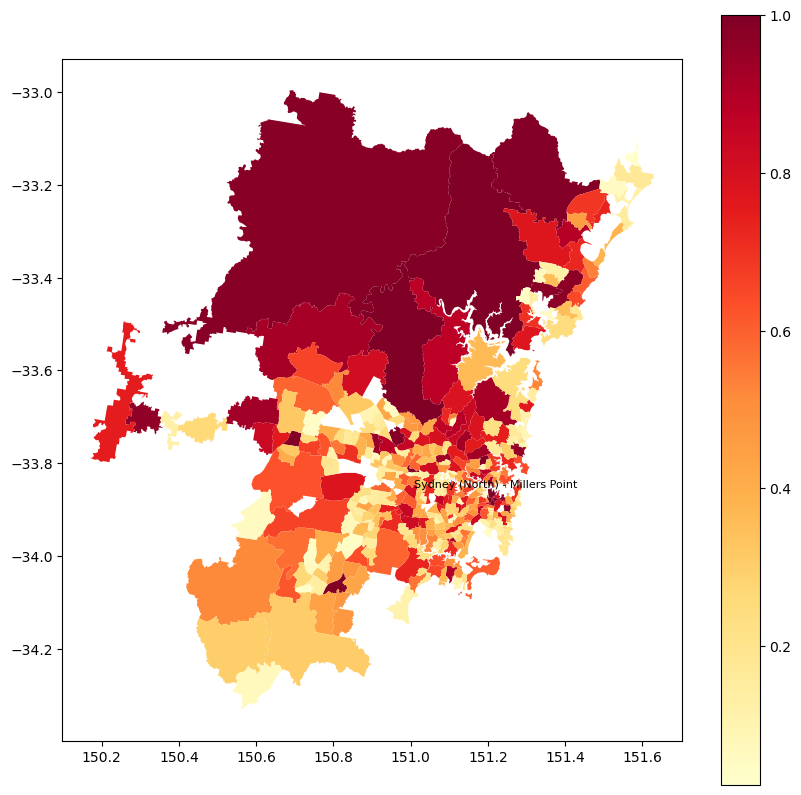

In [52]:
sql = """
SELECT sa2.sa2_code21, sa2.sa2_name21, sa2.geom, s.score
FROM score s
JOIN sa2 ON s.sa2_code = sa2.sa2_code21
"""
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sa2_map_og = gpd.read_postgis(sql, conn)
sa2_map_og.plot(column='score', cmap='YlOrRd', ax=ax, legend=True)

high_score_regions = sa2_map_og[sa2_map_og.score == 1.0]
for x, y, label in zip(high_score_regions.centroid.geometry.x, 
                       high_score_regions.centroid.geometry.y, 
                       high_score_regions.sa2_name21):
    ax.annotate(label, 
                xy=(x, y), 
                xytext=(3,3), 
                textcoords="offset points",
                ha='center', 
                va='bottom', 
                fontsize=8)

In [53]:
# prep: create a new table for the final score and the new score
srid = 4326    
conn.execute("""
DROP TABLE IF EXISTS newscore;
CREATE TABLE newscore (
    sa2_code INT,
    sa2_name VARCHAR(100),
    new_score FLOAT
);"""
)

final_score_new.to_sql('newscore', conn, if_exists='append', index=False)
query(conn, "select * from newscore")

,sa2_code,sa2_name,new_score
0,117031336,Surry Hills,0.995611
1,117031331,Glebe - Forest Lodge,0.989295
2,117031329,Darlinghurst,0.975468
3,117031639,Chippendale,0.909237
4,117031333,Potts Point - Woolloomooloo,0.567996
5,117031646,Ultimo,0.416260
6,117031638,Camperdown - Darlington,0.305324


In [54]:
# SQL query to get updated scores, and retain old scores if new scores aren't available
sql_query = """
SELECT score.sa2_code, score.sa2_name, COALESCE(newscore.new_score, score.score) as score
FROM score
LEFT JOIN newscore
ON score.sa2_code = newscore.sa2_code
ORDER BY score DESC;
"""

# Execute the query and store the result in a dataframe
updated_scores_df = pd.read_sql_query(sql_query, conn)
updated_scores_df.head

<bound method NDFrame.head of       sa2_code                            sa2_name     score
0    117031644      Sydney (North) - Millers Point  1.000000
1    102011030                     Calga - Kulnura  0.999955
2    117031645          Sydney (South) - Haymarket  0.999750
3    115021297  Dural - Kenthurst - Wisemans Ferry  0.999685
4    125041717                  Parramatta - North  0.996333
..         ...                                 ...       ...
347  127011729                           Oran Park  0.042870
348  127031730                      Edmondson Park  0.042134
349  102011033                             Kariong  0.041033
350  123011702                         Spring Farm  0.032743
351  102021052        Summerland Point - Gwandalan  0.023946

[352 rows x 3 columns]>

In [55]:
srid = 4326    
conn.execute("""
DROP TABLE IF EXISTS updatedscore;
CREATE TABLE updatedscore (
    sa2_code INT,
    sa2_name VARCHAR(100),
    score FLOAT
);"""
)

updated_scores_df.to_sql('updatedscore', conn, if_exists='append', index=False)
query(conn, "select * from updatedscore")

,sa2_code,sa2_name,score
0,117031644,Sydney (North) - Millers Point,1.000000
1,102011030,Calga - Kulnura,0.999955
2,117031645,Sydney (South) - Haymarket,0.999750
3,115021297,Dural - Kenthurst - Wisemans Ferry,0.999685
4,125041717,Parramatta - North,0.996333
...,...,...,...
347,127011729,Oran Park,0.042870
348,127031730,Edmondson Park,0.042134
349,102011033,Kariong,0.041033
350,123011702,Spring Farm,0.032743


/var/folders/rj/zy76hkgs4db193fj89bkfcnm0000gn/T/ipykernel_35146/4122426572.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(high_score_regions.centroid.geometry.x,
/var/folders/rj/zy76hkgs4db193fj89bkfcnm0000gn/T/ipykernel_35146/4122426572.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  high_score_regions.centroid.geometry.y,


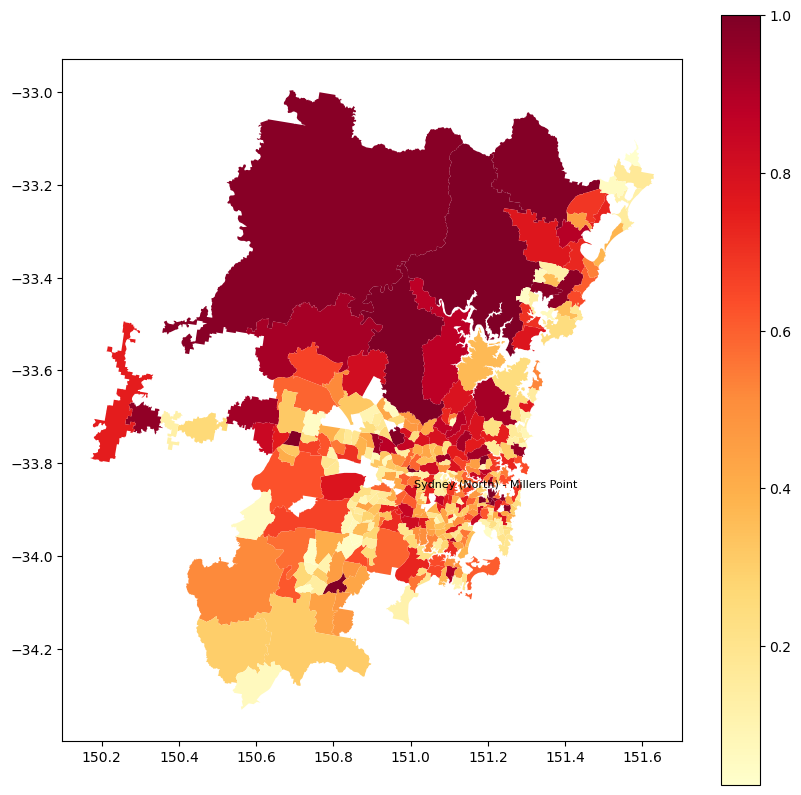

In [56]:
sql = """
SELECT sa2.sa2_code21, sa2.sa2_name21, sa2.geom, u.score
FROM updatedscore u
JOIN sa2 ON u.sa2_code = sa2.sa2_code21
"""
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sa2_map = gpd.read_postgis(sql, conn)
sa2_map.plot(column='score', cmap='YlOrRd', ax=ax, legend=True)

high_score_regions = sa2_map[sa2_map.score == 1.0]
for x, y, label in zip(high_score_regions.centroid.geometry.x, 
                       high_score_regions.centroid.geometry.y, 
                       high_score_regions.sa2_name21):
    ax.annotate(label, 
                xy=(x, y), 
                xytext=(3,3), 
                textcoords="offset points",
                ha='center', 
                va='bottom', 
                fontsize=8)

In [57]:
sa2_map_og.to_file("./score/original.shp")
sa2_map.to_file("./score/new.shp")

### Correlation between score and median income 

In [58]:
# drop the unnecessary columns
income = income.drop(['earners', 'median_age', 'mean_income'], axis=1)
# include the median income data that matches the sa2 region
sql = """
SELECT i.sa2_code, i.sa2_name, i.median_income
FROM income i
JOIN sa2 ON i.sa2_code = sa2.sa2_code21
"""
income = pd.read_sql_query(sql, conn)
income

,sa2_code,sa2_name,median_income
0,102011028.0,Avoca Beach - Copacabana,52450
1,102011029.0,Box Head - MacMasters Beach,48724
2,102011030.0,Calga - Kulnura,46228
3,102011031.0,Erina - Green Point,48292
4,102011032.0,Gosford - Springfield,51999
...,...,...,...
251,128021537.0,Royal National Park,38956
252,128021538.0,Sutherland - Kirrawee,62453
253,128021607.0,Engadine,60914
254,128021608.0,Loftus - Yarrawarrah,60469


In [59]:
# dataframe for income and score
sql = """
SELECT u.score, i.median_income
FROM updatedscore u
JOIN income i ON u.sa2_code = i.sa2_code
"""
income_score = pd.read_sql_query(sql, conn)
income_score

,score,median_income
0,0.999955,46228
1,0.999685,55769
2,0.995611,67312
3,0.992589,52550
4,0.991602,54266
...,...,...
239,0.054884,60645
240,0.053954,49191
241,0.046893,66933
242,0.041033,54900


In [60]:
# correlation coefficient between income and score
income_score.corr()

,score,median_income
score,1.000000,0.153826
median_income,0.153826,1.000000


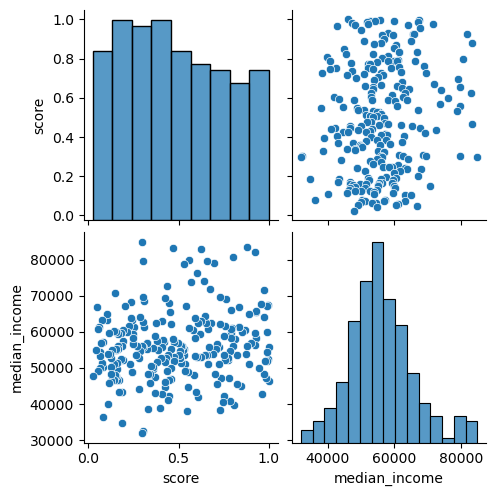

In [61]:
# scatter plots from pairplot
sns.pairplot(income_score)

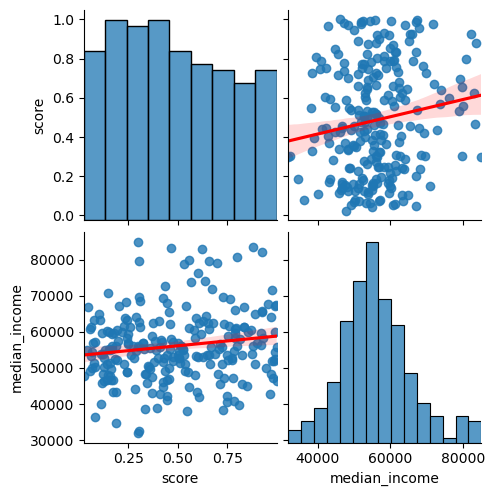

In [62]:
# visualise using pairplot with regression line in different colour
sns.pairplot(income_score, kind='reg', plot_kws={'line_kws':{'color':'red'}})

The correlation coefficient of 0.15 indicates a weak positive correlation between median income and scores. This is further reinforced in the scatter plot, where the points are scattered and do not follow a clear trend. Finally, the regression line is almost horizontal, indicating that there is no significant relationship between the two variables.

In [63]:
# close the connection
conn.close()
db.dispose()